Imports:
------------

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
df = pd.read_csv('atm_data_m2.csv')
df

,Unnamed: 0,atm_name,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn
0,11,Mount Road ATM,MONDAY,NH,W,WWW,1,1,2011,648600.0,897100
1,16,Mount Road ATM,TUESDAY,NH,W,WWW,1,1,2011,648600.0,826000
2,21,Mount Road ATM,WEDNESDAY,NH,W,WWW,1,1,2011,648600.0,754400
3,26,Mount Road ATM,THURSDAY,NH,W,WWW,2,1,2011,648600.0,834200
4,31,Mount Road ATM,FRIDAY,NH,W,WWW,2,1,2011,648600.0,575300
...,...,...,...,...,...,...,...,...,...,...,...
2239,11565,Mount Road ATM,MONDAY,NH,W,HWW,5,9,2017,276058.0,447400
2240,11570,Mount Road ATM,TUESDAY,NH,W,WWW,6,9,2017,276058.0,153800
2241,11575,Mount Road ATM,WEDNESDAY,NH,W,WWW,6,9,2017,276058.0,167100
2242,11580,Mount Road ATM,THURSDAY,NH,W,WWH,6,9,2017,276058.0,317400


Data explanation:
------------------
Data source: https://www.kaggle.com/datasets/nittha/atm-data-m2

atm_name: The name of the ATM (always "Mount Road ATM").

weekday: The day of the week.

festival_religion: Indicates whether the day is associated with a festival or religious holiday .

Likely codes for festivals:

    H: Hindu (e.g., Diwali)
    
    M: Muslim (e.g., Eid)
    
    C: Christian (e.g., Christmas)
    
    N: No festival
    
    NH: National holiday (non-religious)

working_day: Indicates whether the day is a working day (W) or a holiday (H).

holiday_sequence: A sequence indicating the pattern of holidays and working days (e.g., WWW for three consecutive working days).

trans_date_set: The transaction date set.

trans_month: The month of the transaction.

trans_year: The year of the transaction.

prevweek_mean: The mean amount withdrawn in the previous week.

total_amount_withdrawn: The total amount withdrawn on that day.

Data cleaning:
-------------------

In [3]:
df = df.drop(df.columns[[0,1]], axis=1)
df.head(5)

,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn
0,MONDAY,NH,W,WWW,1,1,2011,648600.0,897100
1,TUESDAY,NH,W,WWW,1,1,2011,648600.0,826000
2,WEDNESDAY,NH,W,WWW,1,1,2011,648600.0,754400
3,THURSDAY,NH,W,WWW,2,1,2011,648600.0,834200
4,FRIDAY,NH,W,WWW,2,1,2011,648600.0,575300


No null data

In [4]:
df.count().isna()

weekday                   False
festival_religion         False
working_day               False
holiday_sequence          False
trans_date_set            False
trans_month               False
trans_year                False
prevweek_mean             False
total_amount_withdrawn    False
dtype: bool

removing outliers:
the box plot likely shows dots above the upper whisker indicating outliers.

1.2 = 75th percentile (Q3), values after 1.2 are extreme

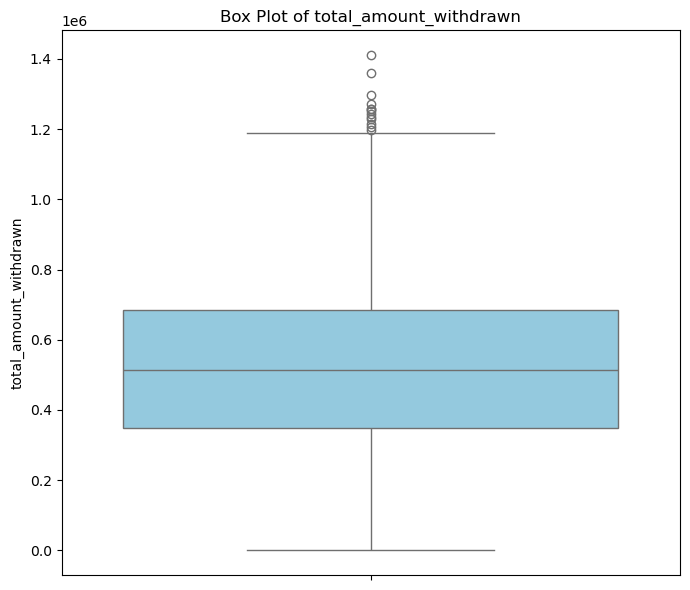

In [5]:

numerical_columns = ["total_amount_withdrawn"]  

plt.figure(figsize=(7, 6))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(1, len(numerical_columns), i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

In [4]:
Q1 = df['total_amount_withdrawn'].quantile(0.25)  
Q3 = df['total_amount_withdrawn'].quantile(0.75) 
IQR = Q3 - Q1                                   
lower_bound = Q1 - 1.5 * IQR                    
upper_bound = Q3 + 1.5 * IQR  
df_clean = df[
    (df['total_amount_withdrawn'] >= lower_bound) & 
    (df['total_amount_withdrawn'] <= upper_bound)
]
df_clean

,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn
0,MONDAY,NH,W,WWW,1,1,2011,648600.0,897100
1,TUESDAY,NH,W,WWW,1,1,2011,648600.0,826000
2,WEDNESDAY,NH,W,WWW,1,1,2011,648600.0,754400
3,THURSDAY,NH,W,WWW,2,1,2011,648600.0,834200
4,FRIDAY,NH,W,WWW,2,1,2011,648600.0,575300
...,...,...,...,...,...,...,...,...,...
2239,MONDAY,NH,W,HWW,5,9,2017,276058.0,447400
2240,TUESDAY,NH,W,WWW,6,9,2017,276058.0,153800
2241,WEDNESDAY,NH,W,WWW,6,9,2017,276058.0,167100
2242,THURSDAY,NH,W,WWH,6,9,2017,276058.0,317400


In [7]:
df_clean.describe()

,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn
count,2231.000000,2231.000000,2231.000000,2.231000e+03,2.231000e+03
mean,3.563873,6.312416,2013.709099,5.145292e+05,5.113589e+05
std,1.758343,3.257640,1.922746,1.935362e+05,2.493895e+05
min,1.000000,1.000000,2011.000000,1.800000e+03,1.000000e+02
25%,2.000000,4.000000,2012.000000,4.197290e+05,3.479000e+05
50%,4.000000,6.000000,2014.000000,5.403860e+05,5.130000e+05
75%,5.000000,9.000000,2015.000000,6.378000e+05,6.819000e+05
max,7.000000,12.000000,2017.000000,1.006829e+06,1.187800e+06


check for spelling mistakes

In [5]:

categorical_columns = df_clean.select_dtypes(include=['object', 'category']).columns

for column in categorical_columns:
    unique_values = df_clean[column].unique()
    print(f"Column: {column}")
    print(f"Unique Values: {unique_values}\n")

Column: weekday
Unique Values: ['MONDAY' 'TUESDAY' 'WEDNESDAY' 'THURSDAY' 'FRIDAY' 'SATURDAY' 'SUNDAY']

Column: festival_religion
Unique Values: ['NH' 'H' 'N' 'M' 'C']

Column: working_day
Unique Values: ['W' 'H']

Column: holiday_sequence
Unique Values: ['WWW' 'WHH' 'HHW' 'HWW' 'WWH' 'HHH' 'WHW' 'HWH']



In [6]:
df_fulldate=df_clean.copy()
df_fulldate["full_date"] = pd.to_datetime(df_fulldate["trans_year"].astype(str) + "-" + 
                                 df_fulldate["trans_month"].astype(str) + "-" + 
                                 df_fulldate["trans_date_set"].astype(str),
                                 errors='coerce')
df_fulldate.head(5)

,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn,full_date
0,MONDAY,NH,W,WWW,1,1,2011,648600.0,897100,2011-01-01
1,TUESDAY,NH,W,WWW,1,1,2011,648600.0,826000,2011-01-01
2,WEDNESDAY,NH,W,WWW,1,1,2011,648600.0,754400,2011-01-01
3,THURSDAY,NH,W,WWW,2,1,2011,648600.0,834200,2011-01-02
4,FRIDAY,NH,W,WWW,2,1,2011,648600.0,575300,2011-01-02


In [7]:
df_fulldate['full_date'] = pd.to_datetime(df_fulldate['full_date'])
df_fulldate


,weekday,festival_religion,working_day,holiday_sequence,trans_date_set,trans_month,trans_year,prevweek_mean,total_amount_withdrawn,full_date
0,MONDAY,NH,W,WWW,1,1,2011,648600.0,897100,2011-01-01
1,TUESDAY,NH,W,WWW,1,1,2011,648600.0,826000,2011-01-01
2,WEDNESDAY,NH,W,WWW,1,1,2011,648600.0,754400,2011-01-01
3,THURSDAY,NH,W,WWW,2,1,2011,648600.0,834200,2011-01-02
4,FRIDAY,NH,W,WWW,2,1,2011,648600.0,575300,2011-01-02
...,...,...,...,...,...,...,...,...,...,...
2239,MONDAY,NH,W,HWW,5,9,2017,276058.0,447400,2017-09-05
2240,TUESDAY,NH,W,WWW,6,9,2017,276058.0,153800,2017-09-06
2241,WEDNESDAY,NH,W,WWW,6,9,2017,276058.0,167100,2017-09-06
2242,THURSDAY,NH,W,WWH,6,9,2017,276058.0,317400,2017-09-06


group by full date and set full date as an index

In [9]:

df_grouped = df_fulldate.groupby('full_date', as_index=True).agg({
    'total_amount_withdrawn': 'sum',
    'weekday' : 'first',
    'festival_religion': 'first',
    'working_day': 'first',
    'holiday_sequence': 'first',
    'prevweek_mean': 'first'
})


In [12]:
df_grouped

,total_amount_withdrawn,weekday,festival_religion,working_day,holiday_sequence,prevweek_mean
full_date,,,,,,
2011-01-01,2477500,MONDAY,NH,W,WWW,648600.0
2011-01-02,3656200,THURSDAY,NH,W,WWW,648600.0
2011-01-03,2311800,TUESDAY,NH,W,WWW,775929.0
2011-01-04,1935600,SUNDAY,H,H,HHH,775929.0
2011-01-05,2196300,FRIDAY,NH,W,WWH,459900.0
...,...,...,...,...,...,...
2017-09-02,1018400,WEDNESDAY,NH,W,WWW,253729.0
2017-09-03,1212000,MONDAY,NH,W,HWW,258558.0
2017-09-04,1374100,SATURDAY,NH,H,WHH,258558.0


In [13]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2011-01-01 to 2017-09-06
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_amount_withdrawn  508 non-null    int64  
 1   weekday                 508 non-null    object 
 2   festival_religion       508 non-null    object 
 3   working_day             508 non-null    object 
 4   holiday_sequence        508 non-null    object 
 5   prevweek_mean           508 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 27.8+ KB


Data visualization:
--------------

Daily Withdrawal Trends Over Time

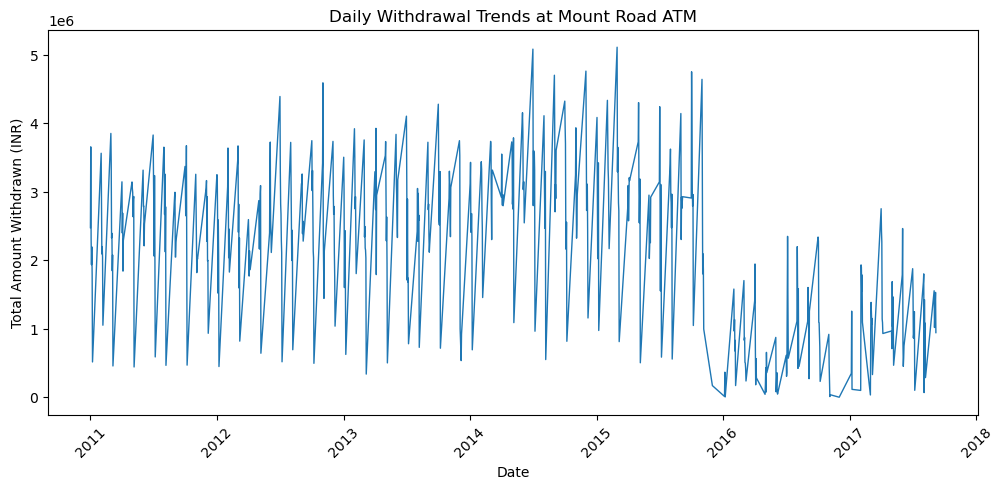

In [14]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_grouped, x="full_date", y="total_amount_withdrawn", linewidth=1)
plt.title("Daily Withdrawal Trends at Mount Road ATM")
plt.xlabel("Date")
plt.ylabel("Total Amount Withdrawn (INR)")
plt.xticks(rotation=45)
plt.show()

total amount withdrawn VS Weekday

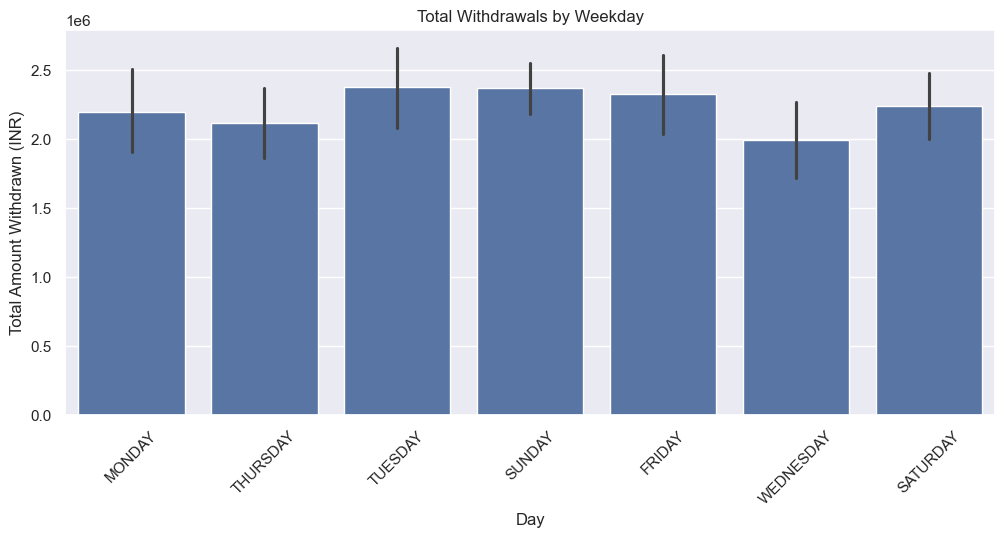

In [15]:

sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 5))
sns.barplot(data=df_grouped, x="weekday", y="total_amount_withdrawn", linewidth=1)
plt.title("Total Withdrawals by Weekday")
plt.xlabel("Day")
plt.ylabel("Total Amount Withdrawn (INR)")
plt.xticks(rotation=45)
plt.show()



total amount withdrawn VS Month

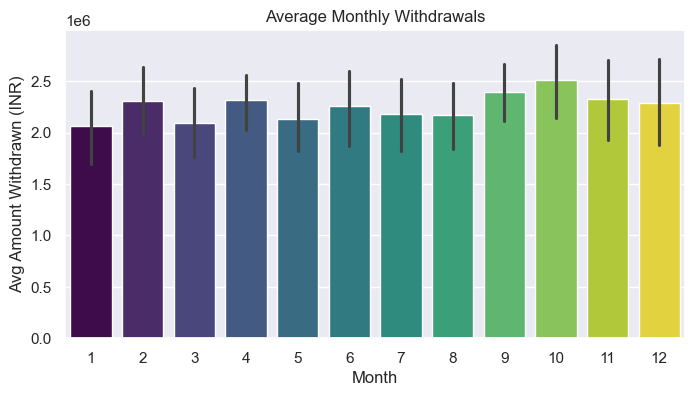

In [16]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_grouped, x=df_grouped.index.month , y="total_amount_withdrawn", hue = df_grouped.index.month ,legend=False, estimator=np.mean , palette="viridis")
plt.title("Average Monthly Withdrawals")
plt.xlabel("Month")
plt.ylabel("Avg Amount Withdrawn (INR)")
plt.show()

total amount withdrawn VS Year

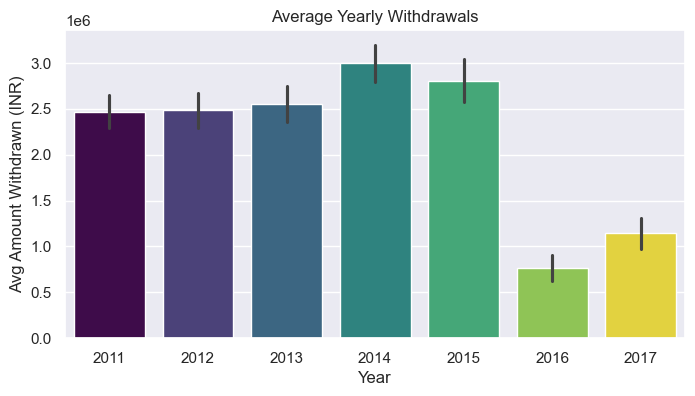

In [17]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_grouped, x=df_grouped.index.year, y="total_amount_withdrawn", hue = df_grouped.index.year ,legend=False, estimator=np.mean , palette="viridis")
plt.title("Average Yearly Withdrawals")
plt.xlabel("Year")
plt.ylabel("Avg Amount Withdrawn (INR)")
plt.show()

Impact of Holidays on Withdrawals

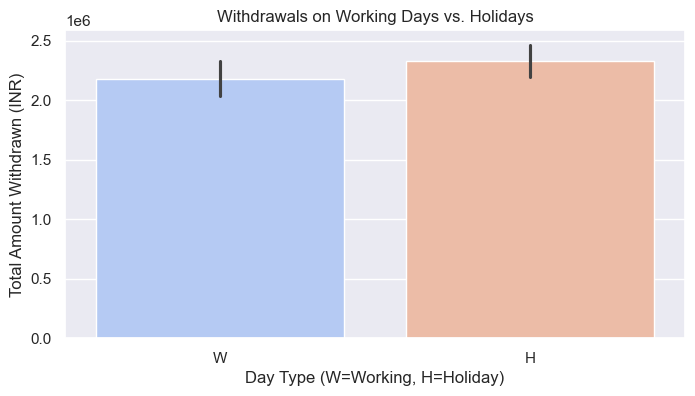

In [18]:

plt.figure(figsize=(8, 4))
sns.barplot(data=df_grouped, x="working_day", y="total_amount_withdrawn", hue="working_day",legend=False, palette="coolwarm")
plt.title("Withdrawals on Working Days vs. Holidays")
plt.xlabel("Day Type (W=Working, H=Holiday)")
plt.ylabel("Total Amount Withdrawn (INR)")
plt.show()



7 for weekly seasonality

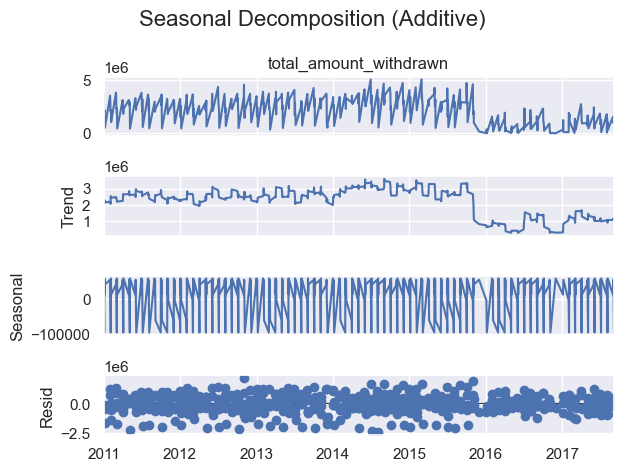

In [19]:

result1 = seasonal_decompose(df_grouped['total_amount_withdrawn'], model='additive', period=7)

result1.plot()
plt.suptitle('Seasonal Decomposition (Additive)', fontsize=16)
plt.tight_layout()
plt.show()


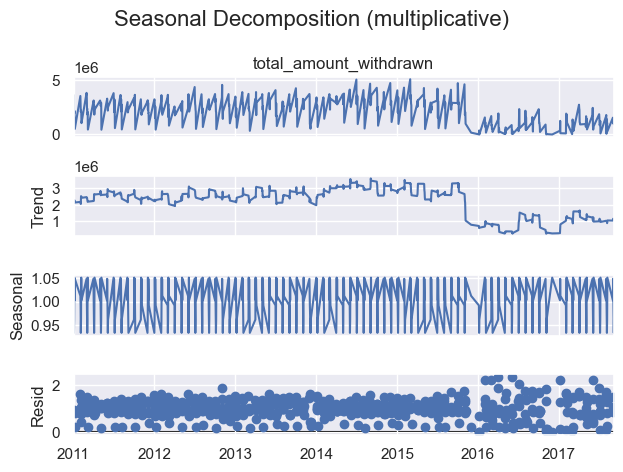

In [20]:
result2 = seasonal_decompose(df_grouped['total_amount_withdrawn'], model='multiplicative', period=7)

result2.plot()
plt.suptitle('Seasonal Decomposition (multiplicative)', fontsize=16)
plt.tight_layout()
plt.show()


Key Insights :
---------------------
1- This data set is highly seasonal, it consistent patterns that repeat at regular intervals like higher withdrawals during certain months or certain weekdays.

2- dates are duplicates due to different withdrawals at the same day.

3- Sunday has the highest withdrawals, it could be due weekend.

4- High withdrawal months are December (12), October (10), September (9) and April (4).
    December is Holiday season (Christmas, New Year).
    October season of Diwali (major Indian festival).
    September (9) and April (4) may be linked to the end of financial quarters or salary cycles.
        
5- there was an Exponential Growth and Sudden Decline.
    it could be due to:
    2014 peak: Economic growth, increased ATM usage.
    2015 slight drop: Possible early signs of digital payments increasing.
    2016 dramatic drop: Demonetization in India (November 2016). The Indian government banned ₹500 and ₹1000 notes, 
    causing a huge cash shortage and forcing people to shift to digital payments.
    ref: https://www.strategy-business.com/article/What-Happened-after-India-Eliminated-Cash
        
6- Withdrawals are higher on holidays.


Business Value:
--------------------
we could develop a pipeline to forecast future withdrawals and allocate resources accordingly.

also, planning for periods of high withdrawal demand.

Data Distribution:
----------------

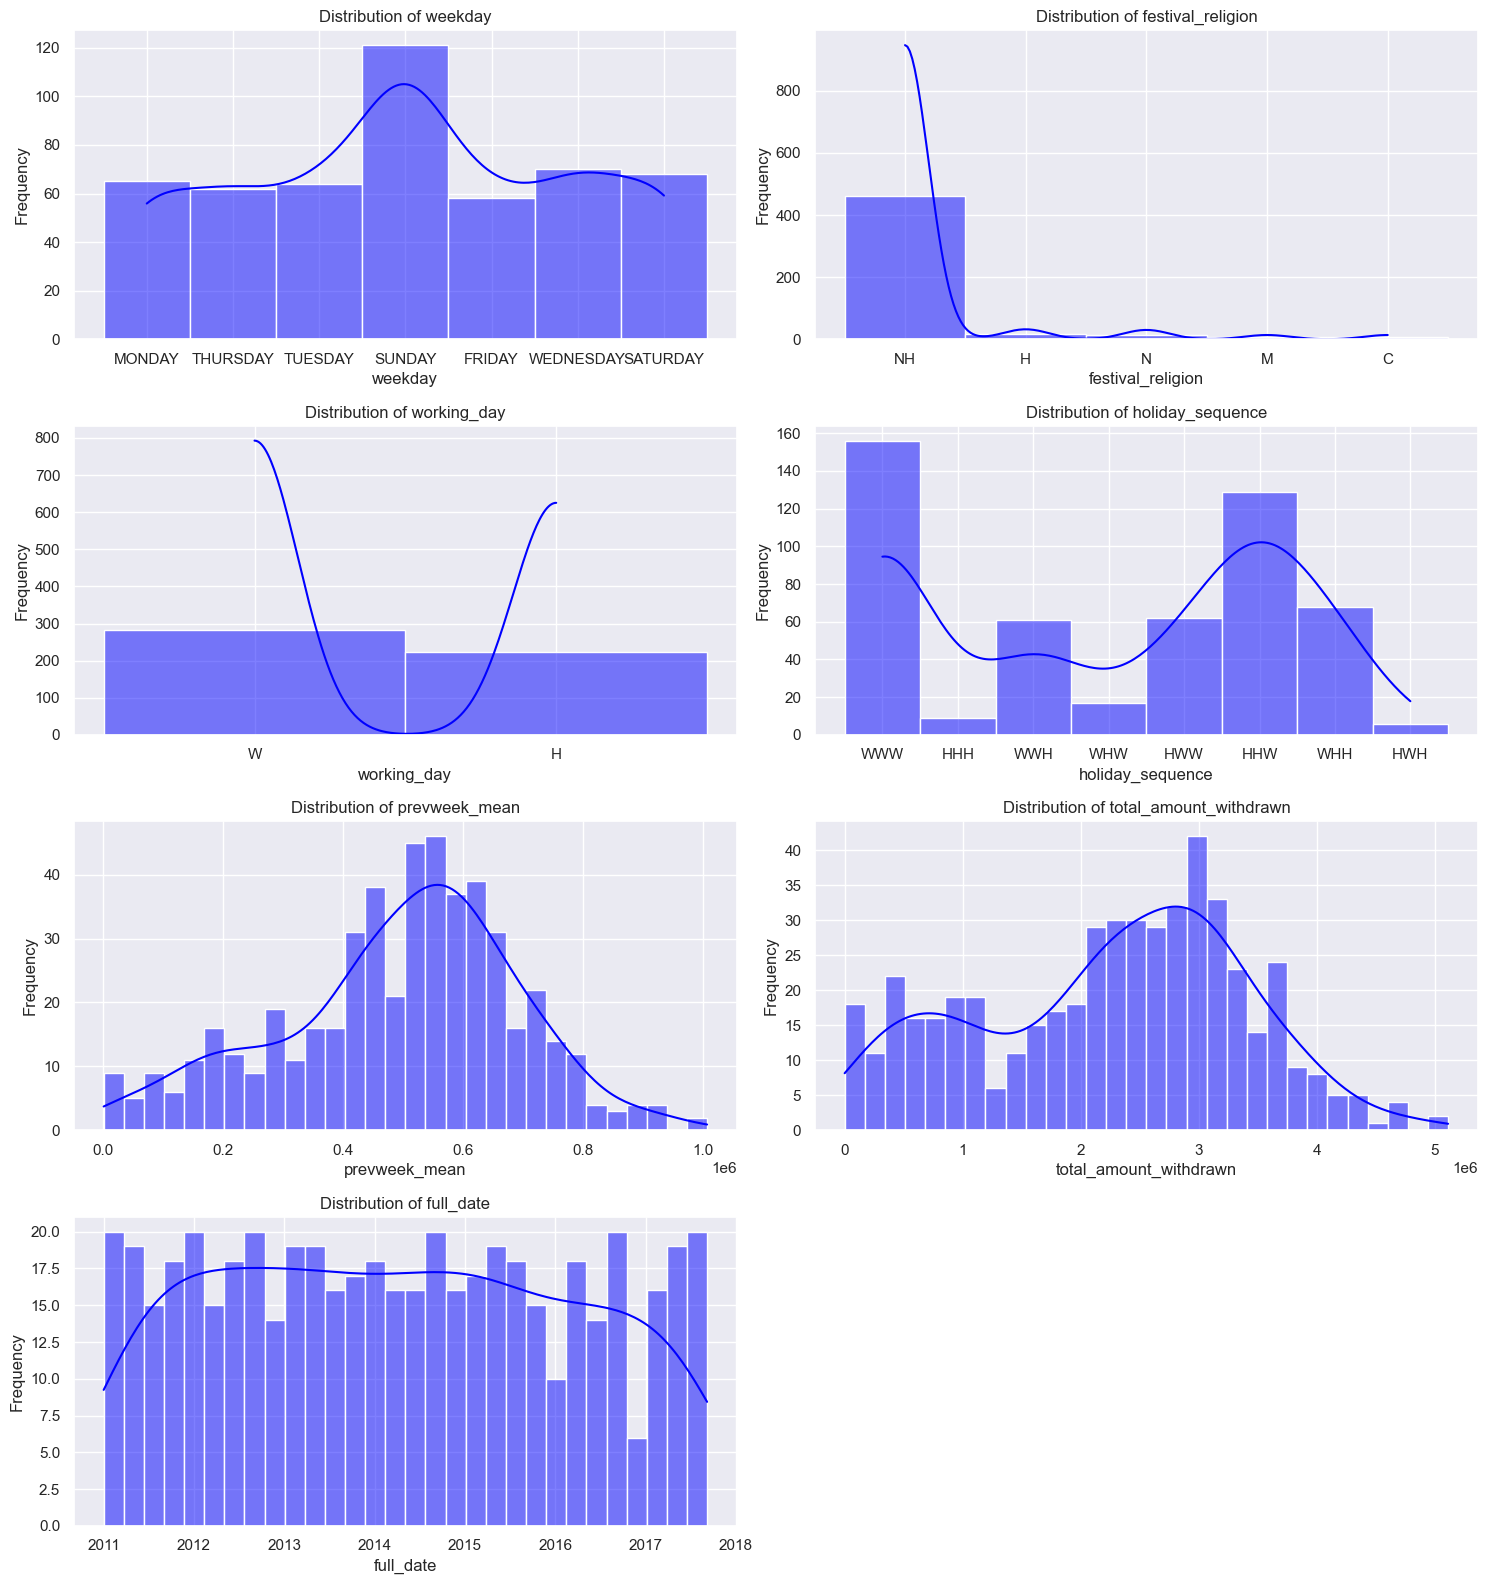

In [21]:

columns_to_check = ["weekday", "festival_religion", "working_day", "holiday_sequence", "prevweek_mean", 
                    "total_amount_withdrawn", "full_date"]
df_dist = df_grouped.reset_index()
num_cols = 2  
num_rows = -(-len(columns_to_check) // num_cols)  
plt.figure(figsize=(15, num_rows * 4))  
for i, col in enumerate(columns_to_check, 1):  
    plt.subplot(num_rows, num_cols, i)  
    sns.histplot(df_dist[col], bins=30, kde=True, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Label Encoding:
----------

Label Encoder used because data has ordinal categories.

In [10]:

label_encoders = {}
for col in [ "weekday", "festival_religion", "working_day", "holiday_sequence"]:
    le = LabelEncoder()
    df_grouped[col] = le.fit_transform(df_grouped[col])  
    label_encoders[col] = le  


In [23]:
df_grouped.head()

,total_amount_withdrawn,weekday,festival_religion,working_day,holiday_sequence,prevweek_mean
full_date,,,,,,
2011-01-01,2477500,1,4,1,7,648600.0
2011-01-02,3656200,4,4,1,7,648600.0
2011-01-03,2311800,5,4,1,7,775929.0
2011-01-04,1935600,3,1,0,0,775929.0
2011-01-05,2196300,0,4,1,6,459900.0


Stationary Test:
---------------

In [24]:

result = adfuller(df_grouped['total_amount_withdrawn'])

adf_statistic = result[0]
p_value = result[1]
used_lag = result[2]
n_obs = result[3]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Used Lags: {used_lag}')
print(f'Number of Observations Used for ADF Regression and Critical Values Calculation: {n_obs}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'    {key}: {value}')

if p_value < 0.05:
    print("The series is likely stationary (reject the null hypothesis).")
else:
    print("The series is likely non-stationary (fail to reject the null hypothesis).")


ADF Statistic: -1.1540184511527742
p-value: 0.6930567015463444
Used Lags: 19
Number of Observations Used for ADF Regression and Critical Values Calculation: 488
Critical Values:
    1%: -3.4438213751870337
    5%: -2.867480869596464
    10%: -2.5699342544006987
The series is likely non-stationary (fail to reject the null hypothesis).


Solve the non-stationary problem:
----
By applying First-order Differencing which involves subtracting the previous value from the current value.

In [25]:
df_stat=df_grouped.copy()
df_stat['target_diff'] = df_stat['total_amount_withdrawn'].diff(1)


In [26]:
df_stat = df_stat.dropna(subset=['target_diff'])
df_stat

,total_amount_withdrawn,weekday,festival_religion,working_day,holiday_sequence,prevweek_mean,target_diff
full_date,,,,,,,
2011-01-02,3656200,4,4,1,7,648600.0,1178700.0
2011-01-03,2311800,5,4,1,7,775929.0,-1344400.0
2011-01-04,1935600,3,1,0,0,775929.0,-376200.0
2011-01-05,2196300,0,4,1,6,459900.0,260700.0
2011-01-06,1777600,6,3,0,5,426915.0,-418700.0
...,...,...,...,...,...,...,...
2017-09-02,1018400,6,4,1,7,253729.0,-536100.0
2017-09-03,1212000,1,4,1,3,258558.0,193600.0
2017-09-04,1374100,2,4,0,4,258558.0,162100.0


In [27]:

result = adfuller(df_stat['target_diff'])

adf_statistic = result[0]
p_value = result[1]
used_lag = result[2]
n_obs = result[3]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Used Lags: {used_lag}')
print(f'Number of Observations Used for ADF Regression and Critical Values Calculation: {n_obs}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'    {key}: {value}')

if p_value < 0.05:
    print("The series is likely stationary (reject the null hypothesis).")
else:
    print("The series is likely non-stationary (fail to reject the null hypothesis).")


ADF Statistic: -6.725780528190497
p-value: 3.392654527316198e-09
Used Lags: 19
Number of Observations Used for ADF Regression and Critical Values Calculation: 487
Critical Values:
    1%: -3.443849184997939
    5%: -2.8674931065091105
    10%: -2.569940776113236
The series is likely stationary (reject the null hypothesis).


ACF & PACF Analysis Before Differencing
--------

ACF: shows Strong Autocorrelation Over Many Lags (delay between past values and the current value),
This means past values strongly influence future values over long periods, 
leading to a possible trend or seasonality, indicating non-stationarity.

PACF: shows Cutoff After a Few Lags, meaning past values (like yesterday’s withdrawals) directly impact today’s value.

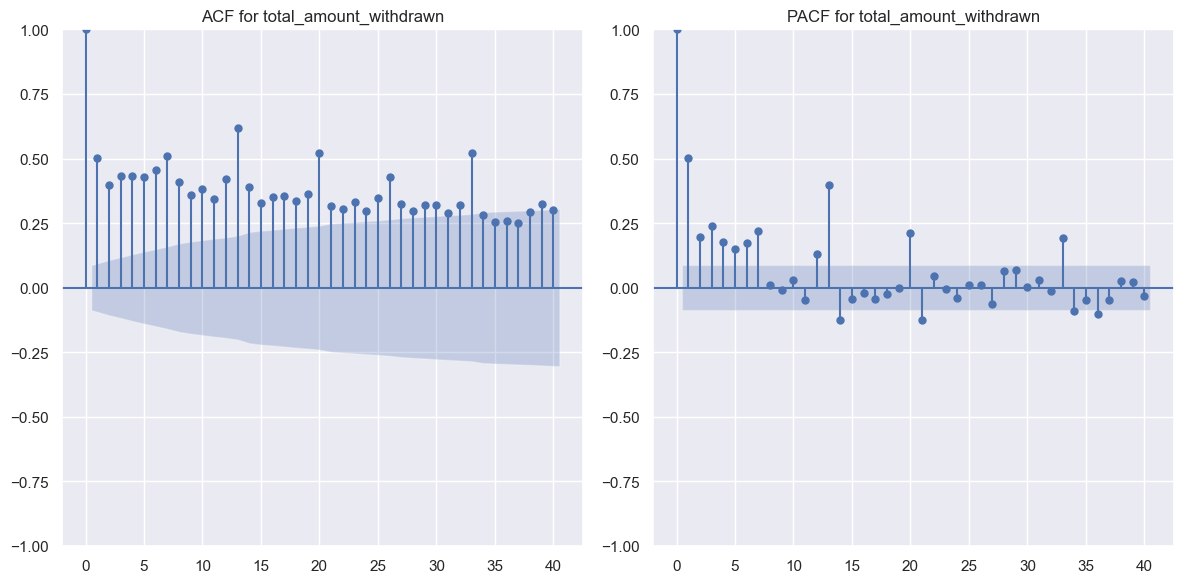

In [28]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  
plot_acf(df_stat['total_amount_withdrawn'], lags=40, ax=plt.gca())
plt.title('ACF for total_amount_withdrawn')

plt.subplot(1, 2, 2)  
plot_pacf(df_stat['total_amount_withdrawn'], lags=40, ax=plt.gca())
plt.title('PACF for total_amount_withdrawn')

plt.tight_layout()
plt.show()


ACF & PACF Analysis After Differencing
-------------

ACF: Since the trend is removed, we can now use models like ARIMA or Prophet for reliable predictions.

PACF: shows only a few significant lags ( only Lag-1 and Lag-2 are significant while others are near zero),
which might leads to than only a few past values are useful for prediction.                                                       

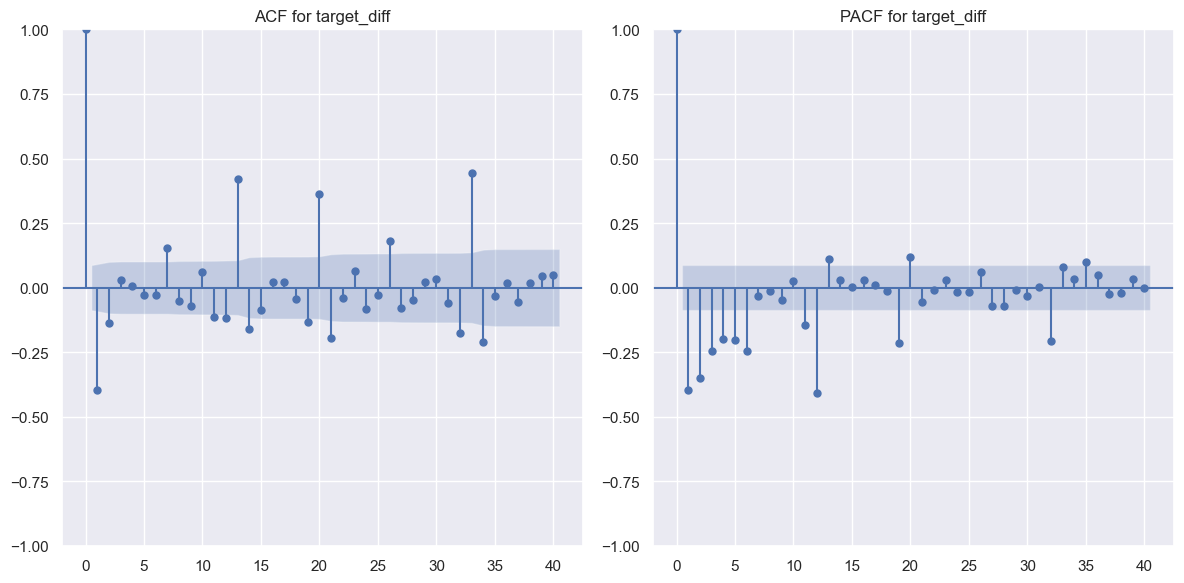

In [29]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  
plot_acf(df_stat['target_diff'], lags=40, ax=plt.gca())
plt.title('ACF for target_diff')

plt.subplot(1, 2, 2)  
plot_pacf(df_stat['target_diff'], lags=40, ax=plt.gca())
plt.title('PACF for target_diff')

plt.tight_layout()
plt.show()

Feature Engineering:
-------------

In [11]:

df_stat = df_grouped.copy()

df_stat['lag_1'] = df_stat['total_amount_withdrawn'].diff(1)
df_stat['lag_7'] = df_stat['total_amount_withdrawn'].shift(7)
df_stat['rolling_mean_7'] = df_stat['total_amount_withdrawn'].rolling(window=7).mean()
df_stat['rolling_std_7'] = df_stat['total_amount_withdrawn'].rolling(window=7).std()
df_stat = df_stat.dropna()

df_stat

,total_amount_withdrawn,weekday,festival_religion,working_day,holiday_sequence,prevweek_mean,lag_1,lag_7,rolling_mean_7,rolling_std_7
full_date,,,,,,,,,,
2011-02-01,3562500,5,4,1,7,387972.0,3047400.0,2477500.0,2.279300e+06,1.082638e+06
2011-02-02,2900500,3,4,0,1,387972.0,-662000.0,3656200.0,2.171343e+06,9.522857e+05
2011-02-03,2092000,0,4,1,7,653929.0,-808500.0,2311800.0,2.139943e+06,9.505045e+05
2011-02-04,2200100,6,2,0,5,511372.0,108100.0,1935600.0,2.177729e+06,9.462753e+05
2011-02-05,2046200,1,4,1,3,444729.0,-153900.0,2196300.0,2.156286e+06,9.474842e+05
...,...,...,...,...,...,...,...,...,...,...
2017-09-02,1018400,6,4,1,7,253729.0,-536100.0,1801000.0,8.842000e+05,5.536773e+05
2017-09-03,1212000,1,4,1,3,258558.0,193600.0,67600.0,1.047686e+06,4.267856e+05
2017-09-04,1374100,2,4,0,4,258558.0,162100.0,1424500.0,1.040486e+06,4.197360e+05


Splitting: Train-test split with test size 30 days ( because be need to forecast up to 30 days)

In [12]:

test_size = 30
train, test = df_stat[:-test_size], df_stat[-test_size:]

print(f"Training size: {len(train)}, Test size: {len(test)}")


Training size: 471, Test size: 30


In [45]:
train_scaled

,total_amount_withdrawn,weekday,festival_religion,working_day,holiday_sequence,prevweek_mean,lag_7,rolling_mean_7,rolling_std_7
full_date,,,,,,,,,
2011-02-01,0.697020,0.833333,1.00,1.0,1.000000,0.384240,0.484729,0.605495,0.698905
2011-02-02,0.567493,0.500000,1.00,0.0,0.142857,0.384240,0.715353,0.573397,0.596925
2011-02-03,0.409302,0.000000,1.00,1.0,1.000000,0.648866,0.452308,0.564061,0.595532
2011-02-04,0.430453,1.000000,0.50,0.0,0.714286,0.507022,0.378700,0.575296,0.592223
2011-02-05,0.400340,0.166667,1.00,1.0,0.428571,0.440713,0.429709,0.568920,0.593169
...,...,...,...,...,...,...,...,...,...
2017-04-05,0.213211,0.000000,1.00,1.0,0.857143,0.441423,0.208300,0.401793,0.547272
2017-04-06,0.182042,1.000000,1.00,1.0,1.000000,0.235388,0.225048,0.392457,0.564411
2017-05-01,0.189301,0.166667,0.75,0.0,0.142857,0.182043,0.064685,0.419510,0.470804


Normalization:
--------------

fit transform training set but only transform testing set

In [13]:

scaler_minmax = MinMaxScaler()
train_scaled = pd.DataFrame(scaler_minmax.fit_transform(train), columns=train.columns,index=train.index)
test_scaled = pd.DataFrame(scaler_minmax.transform(test), columns=test.columns,index=test.index)


In [14]:

X = train_scaled.drop(['lag_1','total_amount_withdrawn'],axis=1)
y = test_scaled['lag_1']

X

,weekday,festival_religion,working_day,holiday_sequence,prevweek_mean,lag_7,rolling_mean_7,rolling_std_7
full_date,,,,,,,,
2011-02-01,0.833333,1.00,1.0,1.000000,0.384240,0.484729,0.605495,0.698905
2011-02-02,0.500000,1.00,0.0,0.142857,0.384240,0.715353,0.573397,0.596925
2011-02-03,0.000000,1.00,1.0,1.000000,0.648866,0.452308,0.564061,0.595532
2011-02-04,1.000000,0.50,0.0,0.714286,0.507022,0.378700,0.575296,0.592223
2011-02-05,0.166667,1.00,1.0,0.428571,0.440713,0.429709,0.568920,0.593169
...,...,...,...,...,...,...,...,...
2017-04-05,0.000000,1.00,1.0,0.857143,0.441423,0.208300,0.401793,0.547272
2017-04-06,1.000000,1.00,1.0,1.000000,0.235388,0.225048,0.392457,0.564411
2017-05-01,0.166667,0.75,0.0,0.142857,0.182043,0.064685,0.419510,0.470804


Training:
---------------

ARIMA Model:
-----------

In [15]:
arima_model= auto_arima(train_scaled['lag_1'],seasonal=False)
print(arima_model.summary())

C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  471
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 292.845
Date:                Tue, 08 Apr 2025   AIC                           -575.689
Time:                        12:21:12   BIC                           -554.915
Sample:                             0   HQIC                          -567.517
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3966      0.035     11.187      0.000       0.327       0.466
ar.L1          0.0976      0.052      1.874      0.061      -0.004       0.200
ar.L2         -0.0942      0.063     -1.489      0.1

In [16]:

forecast = arima_model.predict(n_periods=test_size)

ARIMA_rmse = np.sqrt(mean_squared_error(test_scaled['lag_1'], forecast))

ARIMA_r2 = r2_score(test_scaled['lag_1'], forecast)

print(f'ARIMA RMSE: {ARIMA_rmse}')
print(f'ARIMA R² Score: {ARIMA_r2}')

ARIMA RMSE: 0.1193570477778302
ARIMA R² Score: 0.007879940363657134


C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


SARIMA Model:
----------

In [17]:
sarima_model= auto_arima(train_scaled['lag_1'],seasonal=True)
print(sarima_model.summary())

C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  471
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 292.845
Date:                Tue, 08 Apr 2025   AIC                           -575.689
Time:                        12:21:42   BIC                           -554.915
Sample:                             0   HQIC                          -567.517
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3966      0.035     11.187      0.000       0.327       0.466
ar.L1          0.0976      0.052      1.874      0.061      -0.004       0.200
ar.L2         -0.0942      0.063     -1.489      0.1

In [18]:
forecast = sarima_model.predict(n_periods=test_size)

SARIMA_rmse = np.sqrt(mean_squared_error(test_scaled['lag_1'], forecast))

SARIMA_r2 = r2_score(test_scaled['lag_1'], forecast)

print(f'SARIMA RMSE: {SARIMA_rmse}')
print(f'SARIMA R² Score: {SARIMA_r2}')

SARIMA RMSE: 0.1193570477778302
SARIMA R² Score: 0.007879940363657134


C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


SARIMAX Model:
----------

In [19]:

sarimax_model = SARIMAX(train_scaled['lag_1'], order=(2,0,1), seasonal_order=(0, 0, 0, 7))
model_fit = sarimax_model.fit()

forecast = model_fit.forecast(steps=test_size)

SARIMAX_rmse = np.sqrt(mean_squared_error(test_scaled['lag_1'], forecast))
SARIMAX_r2 = r2_score(test_scaled['lag_1'], forecast)

print(f'SARIMAX RMSE: {SARIMAX_rmse}')
print(f'SARIMAX R² Score: {SARIMAX_r2}')


C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


SARIMAX RMSE: 0.11853315153952965
SARIMAX R² Score: 0.02152945361112446


C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [42]:
train_prophet

,ds,y,weekday,festival_religion,working_day,holiday_sequence,prevweek_mean,lag_7,rolling_mean_7,rolling_std_7
0,2011-02-01,0.697020,0.833333,1.00,1.0,1.000000,0.384240,0.484729,0.605495,0.698905
1,2011-02-02,0.567493,0.500000,1.00,0.0,0.142857,0.384240,0.715353,0.573397,0.596925
2,2011-02-03,0.409302,0.000000,1.00,1.0,1.000000,0.648866,0.452308,0.564061,0.595532
3,2011-02-04,0.430453,1.000000,0.50,0.0,0.714286,0.507022,0.378700,0.575296,0.592223
4,2011-02-05,0.400340,0.166667,1.00,1.0,0.428571,0.440713,0.429709,0.568920,0.593169
...,...,...,...,...,...,...,...,...,...,...
466,2017-04-05,0.213211,0.000000,1.00,1.0,0.857143,0.441423,0.208300,0.401793,0.547272
467,2017-04-06,0.182042,1.000000,1.00,1.0,1.000000,0.235388,0.225048,0.392457,0.564411
468,2017-05-01,0.189301,0.166667,0.75,0.0,0.142857,0.182043,0.064685,0.419510,0.470804
469,2017-05-02,0.138821,0.333333,1.00,0.0,0.571429,0.182043,0.538633,0.332716,0.390296


Facebook Prophet Model:
---

In [24]:


train_prophet = train_scaled.reset_index().rename(columns={'full_date': 'ds', 'lag_1': 'y'})
test_prophet = test_scaled.reset_index().rename(columns={'full_date': 'ds', 'lag_1': 'y'})


model = Prophet(
    changepoint_prior_scale=0.2,  
    seasonality_prior_scale=10,    
    weekly_seasonality=True
)


feature_columns = [col for col in train_prophet.columns if col not in ['ds', 'y']]
for feature in feature_columns:
    model.add_regressor(feature)


model.fit(train_prophet)

future = test_prophet.copy() 

forecast_prophet = model.predict(future)

forecast_prophet_values = forecast_prophet['yhat'].values

prophet_rmse = np.sqrt(mean_squared_error(test_prophet['y'], forecast_prophet_values))
prophet_r2 = r2_score(test_prophet['y'], forecast_prophet_values)

print(f'Facebook Prophet RMSE: {prophet_rmse}')
print(f'Facebook Prophet R² Score: {prophet_r2}')


12:27:08 - cmdstanpy - INFO - Chain [1] start processing
12:27:08 - cmdstanpy - INFO - Chain [1] done processing


Facebook Prophet RMSE: 0.08242217538131237
Facebook Prophet R² Score: 0.5268964142462219


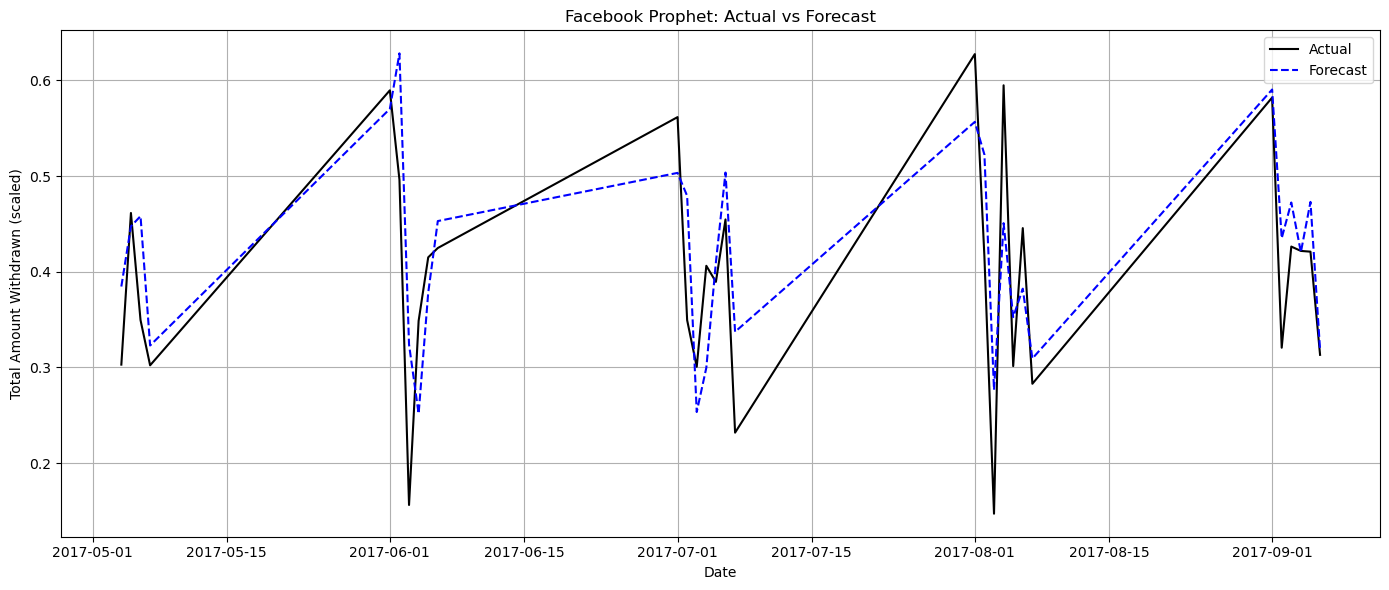

In [25]:

df_merged = forecast_prophet[['ds', 'yhat']].merge(test_prophet[['ds', 'y']], on='ds')

plt.figure(figsize=(14, 6))
plt.plot(df_merged['ds'], df_merged['y'], label='Actual', color='black')
plt.plot(df_merged['ds'], df_merged['yhat'], label='Forecast', color='blue', linestyle='--')
plt.title('Facebook Prophet: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Total Amount Withdrawn (scaled)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


LSTM Model:
---------

In [22]:
#look 7 days in the past 

seq_length = 7

all_features = X.values
target_values = y.values

def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        if i + seq_length >= len(target):
            break
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

X_lstm, y_lstm = create_sequences(all_features, target_values, seq_length)

test_size = int(0.2 * len(y_lstm))
X_train, X_test = X_lstm[:-test_size], X_lstm[-test_size:]
y_train, y_test = y_lstm[:-test_size], y_lstm[-test_size:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Number of features: {X_train.shape[2]}")

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])


optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='huber')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5)

history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop, lr_scheduler])

lstm_predictions = model.predict(X_test)


lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_r2 = r2_score(y_test, lstm_predictions)

print(f"\n LSTM RMSE: {lstm_rmse}")
print(f" LSTM R² Score: {lstm_r2}")


X_train shape: (19, 7, 8)
X_test shape: (4, 7, 8)
Number of features: 8
Epoch 1/10


C:\Users\ra255087\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0758 - val_loss: 0.0368 - learning_rate: 5.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step - loss: 0.0582 - val_loss: 0.0264 - learning_rate: 5.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.0486 - val_loss: 0.0184 - learning_rate: 5.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - loss: 0.0400 - val_loss: 0.0123 - learning_rate: 5.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.0396 - val_loss: 0.0074 - learning_rate: 5.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 0.0286 - val_loss: 0.0037 - learning_rate: 5.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.0210 - val_loss: 0.0015 - learning_rate: 5.0000e-04
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.0195 - val_loss: 7.7853e-04 - learning_rate: 5.0000e-04
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0210 - val_loss: 0.0011 - learning_rate: 5.0000e-04
Ep

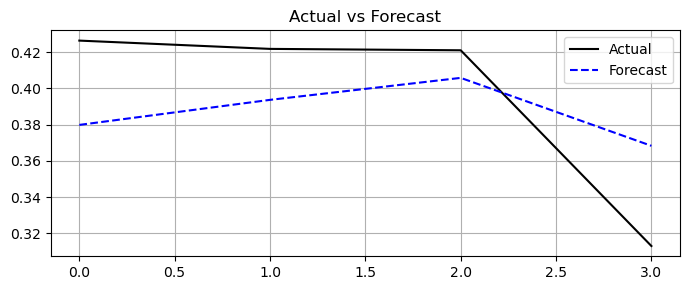

In [23]:
plt.figure(figsize=(7, 3))
plt.plot(y_test,  label='Actual', color='black')
plt.plot(lstm_predictions, label='Forecast', color='blue', linestyle='--')
plt.legend(); plt.title('Actual vs Forecast'); 
plt.grid()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
results = {
    'Model': ['ARIMA', 'SARIMA', 'SARIMAX', 'Facebook Prophet', 'LSTM'],
    'RMSE': [ARIMA_rmse, SARIMA_rmse, SARIMAX_rmse, prophet_rmse, lstm_rmse],
    'R² Score': [ARIMA_r2, SARIMA_r2, SARIMAX_r2, prophet_r2, lstm_r2]
}

results_df = pd.DataFrame(results)
results_df

,Model,RMSE,R² Score
0,ARIMA,0.119357,0.007880
1,SARIMA,0.119357,0.007880
2,SARIMAX,0.118533,0.021529
3,Facebook Prophet,0.082422,0.526896
4,LSTM,0.039459,0.313769


#1. ARIMA / SARIMA
-------------------
🔸 RMSE is high and R² is near zero.

🔸 the models barely improve over a naive baseline.

🔸 They're likely missing the complex patterns and seasonality in this data.

#2. SARIMAX
-----
🔸 Slight improvement over SARIMA.

🔸 Still too linear and rigid for this dataset’s complexity.

#3. Facebook Prophet
----------
🔸 Much better performance ,RMSE drops, and R² = 0.53, meaning it explains over half the variance.

🔸 Prophet captures trend, seasonality, and handles holidays and changepoints well.

#4. LSTM
----------
🔸 Lowest RMSE, meaning predictions are closest to actual values on average.

🔸 R² Score = 0.31, lower than Prophet, so it doesn't explain as much variance.



Conclusion:
-------
This dataset is highly complex and seasonal. Classical models (ARIMA, SARIMA, SARIMAX) struggled to capture complex patterns.  Facebook Prophet has strong performance in modeling trend and seasonality while LSTM achieved the lowest RMSE.

What's next?
-------
A potential hybrid approach combining Prophet's long-term forecasting and LSTM’s short-term precision could further enhance performance.